In [1]:
%reset -f

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import ee
ee.Authenticate()

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime as dt
from datetime import timedelta
import os
import scipy as scipy
import statsmodels.api as sm
from google.colab import data_table
data_table.enable_dataframe_formatter()


stationIDLINK = 'https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt'
metadataLINK = 'https://www.ncei.noaa.gov/pub/data/ghcn/daily/ghcnd-inventory.txt'
dataLINK = 'https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access'
outFILE = '/content/drive/My Drive/Colab Notebooks/ghcn_tseries.csv'

dates = []
start_date = dt(1974, 1, 1, 0, 0)
end_date = dt(2013, 12, 31, 0, 0)
date = start_date
while date <= end_date:
  dates.append(date)
  date = date + timedelta(days=1)


"""
url = stationIDLINK
req = requests.get(url)
text = req.text


keepers_step_one = []
lines = (line for line in text.splitlines())
for line in lines:
  row = line.split()
  stationID = row[0]
  if stationID[:2] == 'US':
    state = row[4]
    if state in ['AZ', 'NM', 'NV', 'UT']:
      keepers_step_one.append(stationID)

url = metadataLINK
req = requests.get(url)
text = req.text

keepers_step_two = []
lines = (line for line in text.splitlines())
for line in lines:
  row = line.split()
  if 'PRCP' in row and row[0] in keepers_step_one:
    if int(row[4]) <= 1974 and int(row[5]) >= 2013:
      keepers_step_two.append(row[0])

#No html address
bad = []
for keeper in keepers_step_two:

  try:
    ct = 0
    url = dataLINK + '/' + keeper + '.csv'
    req = requests.get(url)
    text = req.text
    if not '404 Not Found' in text:
      ct = 0
      lines = [line for line in text.splitlines()]
      save_lines = []
      hdrs = lines[0].split(',')
      prcp_i = hdrs.index('"PRCP"')
      date_i = hdrs.index('"DATE"')
      for line in lines[1:]:
        row = line.split('","')
        name_no_comma = row[5].replace(',', '')
        line = line.replace(row[5], name_no_comma)
        line = line.replace('","', ',')
        row = line.split(',')
        date = dt.strptime(row[date_i].strip('"'), '%Y-%m-%d')
        prcp = row[prcp_i].strip('"')
        if date.year >= 1974 and date.year <= 2013:
          if prcp != '' and not any([s in prcp for s in ['P', 'T', 'H', '9999']]):
            prcp = float(prcp)
            ct += 1

      if float(ct)/float(len(dates))*100. < 98.:
        print(str(float(ct)/float(len(dates))*100))
        bad.append(keeper)

    else:
      bad.append(keeper)

  except requests.exceptions.Timeout:
    pass


keepers_step_three = [k for k in keepers_step_two if k not in bad]
keepers = keepers_step_three
"""


keepers = ['USW00023169', 'USC00425733', 'USC00028619', 'USW00023050']


#DATA ANALYSIS


df = pd.DataFrame()
df['year'] = [date.year for date in dates]
df['month'] = [date.month for date in dates]
df['day'] = [date.day for date in dates]

i = 0
done = False
while done == False:
  keeper = keepers[i]
  print(i)
  url = dataLINK + '/' + keeper + '.csv'
  req = requests.get(url)
  text = req.text

  data_dict = {'date':[], 'precip':[]}
  lines = [line for line in text.splitlines()]
  hdrs = lines[0].split(',')
  prcp_col_i = hdrs.index('"PRCP"')
  date_col_i = hdrs.index('"DATE"')
  date_i = 0
  for line in lines[1:]:
    row = line.split('","')
    name_no_comma = row[5].replace(',', '')
    line = line.replace(row[5], name_no_comma)
    line = line.replace('","', ',')
    row = line.split(',')
    lon = row[3]
    lat = row[2]
    date = dt.strptime(row[date_col_i].strip('"'), '%Y-%m-%d')
    prcp = row[prcp_col_i].strip('"')

    if date.year >= 1974 and date.year <= 2013:

      if date == dates[date_i]:

        if prcp != '' and not any([s in prcp for s in ['P', 'T', 'H', '9999']]):
          prcp = float(prcp)/10.
        else:
          prcp = 0.

        df.at[date_i, keeper] = prcp
        date_i += 1

      else:

        while date >= dates[date_i]:
          df.at[date_i, keeper] = 0.
          date_i += 1

  while date < dates[-1]:
    df.at[keeper, date_i] = 0.
    date = dates[date_i]
    date_i += 1

  i += 1

  if i == len(keepers):
    done = True

display(df)
df.to_csv(outFILE)




In [ ]:
import ee
ee.Initialize(project='ee-andrewfullhart')

dataset = ee.ImageCollection('IDAHO_EPSCOR/MACAv2_METDATA') \
            .filter(ee.Filter.date('1974-01-01', '2014-01-01'))\

modelfilter = ee.Filter.Or(
              ee.Filter.eq('scenario', 'historical'),
              ee.Filter.eq('scenario', 'rcp45'))
dataset = dataset.filter(modelfilter)
dataset = dataset.filter(ee.Filter.eq('model', 'CCSM4'))

ic = dataset.select('pr')

nv_point = ee.Geometry.Point(-115.17, 36.08)
ut_point = ee.Geometry.Point(-109.55, 38.58)
az_point = ee.Geometry.Point(-110.07, 31.72)
nm_point = ee.Geometry.Point(-106.62, 35.05)
point = nv_point
points = ee.List([nv_point, ut_point, az_point, nm_point])
point_indxs = ee.List.sequence(0, points.size().subtract(1))


prop_list = ic.getRegion(point, 100)

def props_fn(propsobj):
    props = ee.List(propsobj)
    return props.get(0)

dates_list = ee.List(prop_list.slice(1).map(props_fn))
dates_indxs = ee.List.sequence(0, dates_list.size().subtract(1))


def points_fn(pointiobj):

  point = ee.Geometry(points.get(ee.Number(pointiobj)))
  point_name = ee.String(point_names.get(ee.Number(pointiobj)))
  prop_list = ic.getRegion(point, 100)

  def props_fn(propsobj):
      props = ee.List(propsobj)
      return ee.Number(props.get(4))

  point_list = ee.List(prop_list.slice(1).map(props_fn))

  return point_list


out_list = ee.List(point_indxs.map(points_fn))
print(out_list.size().getInfo())
print(ee.List(out_list.get(0)).size().getInfo())


def zip_fc_fn(indxobj):
  i = ee.Number(indxobj)
  date = dates_list.get(i)
  a_p = ee.List(out_list.get(0)).get(i)
  b_p = ee.List(out_list.get(1)).get(i)
  c_p = ee.List(out_list.get(2)).get(i)
  d_p = ee.List(out_list.get(3)).get(i)
  return ee.Feature(None, {'date':date, 'USW00023169':a_p, 'USC00425733':b_p, 'USC00028619':c_p, 'USW00023050':d_p})


out_fc = ee.FeatureCollection(dates_indxs.map(zip_fc_fn))

task = ee.batch.Export.table.toDrive(collection=out_fc,
                           description='maca_tseries',
                           folder='GEE_Downloads')

task.start()


4


14610


Text(0.5, 0, '                                                                                                            Daily Intensity for Non-Zero Daily Accumulations (mm d⁻¹)')

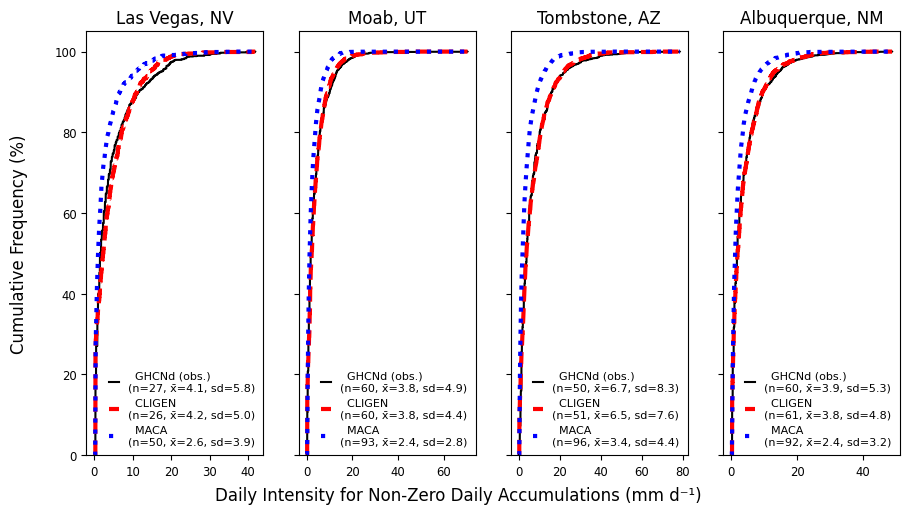

In [14]:
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import numpy as np
import os


ghcn_FILE = '/content/drive/My Drive/Colab Notebooks/MACA_CLIGEN_Comparison/ghcn_tseries.csv'
maca_FILE = '/content/drive/My Drive/Colab Notebooks/MACA_CLIGEN_Comparison/maca_tseries.csv'
gridA_FILE = '/content/drive/My Drive/Colab Notebooks/MACA_CLIGEN_Comparison/CLIGEN_output/nv264436.txt'
gridB_FILE = '/content/drive/My Drive/Colab Notebooks/MACA_CLIGEN_Comparison/CLIGEN_output/ut425733.txt'
gridC_FILE = '/content/drive/My Drive/Colab Notebooks/MACA_CLIGEN_Comparison/CLIGEN_output/az028619.txt'
gridD_FILE = '/content/drive/My Drive/Colab Notebooks/MACA_CLIGEN_Comparison/CLIGEN_output/nm290234.txt'


cligenfiles = [gridA_FILE, gridB_FILE, gridC_FILE, gridD_FILE]
cligen_list_list = [[], [], [], []]
for i in range(4):

  with open(cligenfiles[i]) as f:
    next(f); next(f); next(f); next(f); next(f)
    next(f); next(f); next(f); next(f); next(f)
    next(f); next(f); next(f); next(f); next(f)

    for line in f:
      row = line.split()
      if row != []:
        if float(row[3]) != 0.0:
          cligen_list_list[i].append(float(row[3]))



maca_df = pd.read_csv(maca_FILE)
maca_list_list = [maca_df.loc[maca_df['USW00023169'] > 0.]['USW00023169'].to_list(),
                  maca_df.loc[maca_df['USC00425733'] > 0.]['USC00425733'].to_list(),
                  maca_df.loc[maca_df['USC00028619'] > 0.]['USC00028619'].to_list(),
                  maca_df.loc[maca_df['USW00023050'] > 0.]['USW00023050'].to_list()]

ghcn_df = pd.read_csv(ghcn_FILE)
ghcn_list_list = [ghcn_df.loc[ghcn_df['USW00023169'] > 0.]['USW00023169'].to_list(),
                  ghcn_df.loc[ghcn_df['USC00425733'] > 0.]['USC00425733'].to_list(),
                  ghcn_df.loc[ghcn_df['USC00028619'] > 0.]['USC00028619'].to_list(),
                  ghcn_df.loc[ghcn_df['USW00023050'] > 0.]['USW00023050'].to_list()]


binsA = np.linspace(0,
                    max(max(ghcn_list_list[0]), max(cligen_list_list[0]), max(maca_list_list[0])), 1001)

binsB = np.linspace(0,
                    max(max(ghcn_list_list[1]), max(cligen_list_list[1]), max(maca_list_list[1])), 1001)

binsC = np.linspace(0,
                    max(max(ghcn_list_list[2]), max(cligen_list_list[2]), max(maca_list_list[2])), 1001)

binsD = np.linspace(0,
                    max(max(ghcn_list_list[3]), max(cligen_list_list[3]), max(maca_list_list[3])), 1001)


bins_list = [binsA, binsB, binsC, binsD]

p_list_list = [ghcn_list_list[0], cligen_list_list[0], maca_list_list[0],
               ghcn_list_list[1], cligen_list_list[1], maca_list_list[1],
               ghcn_list_list[2], cligen_list_list[2], maca_list_list[2],
               ghcn_list_list[3], cligen_list_list[3], maca_list_list[3]]

p_y_list_list = [[], [], [], [], [], [], [], [], [], [], [], []]
record_i = 0
for bin_i, bins in enumerate(bins_list):

  for elem in range(len(['ghcn', 'cligen', 'maca'])):

    pcp_list = p_list_list[record_i]
    p_y_ct = 0

    for i, elem in enumerate(bins[:-1]):

      for val in pcp_list:
        if val >= bins[i] and val < bins[i+1]:
          p_y_ct += 1

      if i == len(bins)-2 and max(pcp_list) == bins[-1]:
        p_y_ct += 1

      p_y_list_list[record_i].append((float(p_y_ct)/float(len(pcp_list)))*100)

    record_i += 1



params = {'xtick.labelsize':'small',
          'ytick.labelsize':'small'}
pylab.rcParams.update( params )

f, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, sharey=True, sharex=False, facecolor='w')
f.set_size_inches(10.5, 5.5)

ghcn, = ax0.plot(bins_list[0][:-1], p_y_list_list[0], color='black')
cligen, = ax0.plot(bins_list[0][:-1], p_y_list_list[1], color='red', linestyle='--', linewidth=3)
maca, = ax0.plot(bins_list[0][:-1], p_y_list_list[2], color='blue', linestyle=':', linewidth=3)
ax0.set_title('Las Vegas, NV')
ax0.legend(handles=[ghcn, cligen, maca], labels=['  GHCNd (obs.)\n(n={}, x̄={}, sd={})'.format(round(len(p_list_list[0])/40), round(np.mean(p_list_list[0]), 1), round(np.std(p_list_list[0]), 1)), '  CLIGEN\n(n={}, x̄={}, sd={})'.format(round(len(p_list_list[1])/40), round(np.mean(p_list_list[1]), 1), round(np.std(p_list_list[1]), 1)), '  MACA\n(n={}, x̄={}, sd={})'.format(round(len(p_list_list[2])/40), round(np.mean(p_list_list[2]), 1), round(np.std(p_list_list[2]), 1))], loc='lower right', fontsize=8, frameon=False, borderpad=0.25, handlelength=0.9)
ax0.set_ylim(0, 105)

ghcn, = ax1.plot(bins_list[1][:-1], p_y_list_list[3], color='black')
cligen, = ax1.plot(bins_list[1][:-1], p_y_list_list[4], color='red', linestyle='--', linewidth=3)
maca, = ax1.plot(bins_list[1][:-1], p_y_list_list[5], color='blue', linestyle=':', linewidth=3)
ax1.set_title('Moab, UT')
ax1.legend(handles=[ghcn, cligen, maca], labels=['  GHCNd (obs.)\n(n={}, x̄={}, sd={})'.format(round(len(p_list_list[3])/40), round(np.mean(p_list_list[3]), 1), round(np.std(p_list_list[3]), 1)), '  CLIGEN\n(n={}, x̄={}, sd={})'.format(round(len(p_list_list[4])/40), round(np.mean(p_list_list[4]), 1), round(np.std(p_list_list[4]), 1)), '  MACA\n(n={}, x̄={}, sd={})'.format(round(len(p_list_list[5])/40), round(np.mean(p_list_list[5]), 1), round(np.std(p_list_list[5]), 1))], loc='lower right', fontsize=8, frameon=False, borderpad=0.25, handlelength=0.9)
ax1.set_ylim(0, 105)

ghcn, = ax2.plot(bins_list[2][:-1], p_y_list_list[6], color='black')
cligen, = ax2.plot(bins_list[2][:-1], p_y_list_list[7], color='red', linestyle='--', linewidth=3)
maca, = ax2.plot(bins_list[2][:-1], p_y_list_list[8], color='blue', linestyle=':', linewidth=3)
ax2.set_title('Tombstone, AZ')
ax2.legend(handles=[ghcn, cligen, maca], labels=['  GHCNd (obs.)\n(n={}, x̄={}, sd={})'.format(round(len(p_list_list[6])/40), round(np.mean(p_list_list[6]), 1), round(np.std(p_list_list[6]), 1)), '  CLIGEN\n(n={}, x̄={}, sd={})'.format(round(len(p_list_list[7])/40), round(np.mean(p_list_list[7]), 1), round(np.std(p_list_list[7]), 1)), '  MACA\n(n={}, x̄={}, sd={})'.format(round(len(p_list_list[8])/40), round(np.mean(p_list_list[8]), 1), round(np.std(p_list_list[8]), 1))], loc='lower right', fontsize=8, frameon=False, borderpad=0.25, handlelength=0.9)
ax2.set_ylim(0, 105)

ghcn, = ax3.plot(bins_list[3][:-1], p_y_list_list[9], color='black')
cligen, = ax3.plot(bins_list[3][:-1], p_y_list_list[10], color='red', linestyle='--', linewidth=3)
maca, = ax3.plot(bins_list[3][:-1], p_y_list_list[11], color='blue', linestyle=':', linewidth=3)
ax3.set_title('Albuquerque, NM')
ax3.legend(handles=[ghcn, cligen, maca], labels=['  GHCNd (obs.)\n(n={}, x̄={}, sd={})'.format(round(len(p_list_list[9])/40), round(np.mean(p_list_list[9]), 1), round(np.std(p_list_list[9]), 1)), '  CLIGEN\n(n={}, x̄={}, sd={})'.format(round(len(p_list_list[10])/40), round(np.mean(p_list_list[10]), 1), round(np.std(p_list_list[10]), 1)), '  MACA\n(n={}, x̄={}, sd={})'.format(round(len(p_list_list[11])/40), round(np.mean(p_list_list[11]), 1), round(np.std(p_list_list[11]), 1))], loc='lower right', fontsize=8, frameon=False, borderpad=0.25, handlelength=0.9)
ax3.set_ylim(0, 105)


ax0.set_ylabel('Cumulative Frequency (%)\n', size=12)
ax0.set_xlabel('                                                                                                            Daily Intensity for Non-Zero Daily Accumulations (mm d⁻¹)', size=12, labelpad=6)




In [ ]:
import pandas as pd
from datetime import datetime as dt
from datetime import timedelta
from google.colab import data_table
data_table.enable_dataframe_formatter()


ghcn_FILE = '/content/drive/My Drive/Colab Notebooks/MACA_CLIGEN_Comparison/ghcn_tseries.csv'
maca_FILE = '/content/drive/My Drive/Colab Notebooks/MACA_CLIGEN_Comparison/maca_tseries.csv'
cligenA_FILE = '/content/drive/My Drive/Colab Notebooks/MACA_CLIGEN_Comparison/nv264436.txt'
cligenB_FILE = '/content/drive/My Drive/Colab Notebooks/MACA_CLIGEN_Comparison/ut425733.txt'
cligenC_FILE = '/content/drive/My Drive/Colab Notebooks/MACA_CLIGEN_Comparison/az028619.txt'
cligenD_FILE = '/content/drive/My Drive/Colab Notebooks/MACA_CLIGEN_Comparison/nm290234.txt'

prnA_FILE = '/content/drive/My Drive/Colab Notebooks/MACA_CLIGEN_Comparison/nv264436_ghcn.prn'
prnB_FILE = '/content/drive/My Drive/Colab Notebooks/MACA_CLIGEN_Comparison/nv264436_maca.prn'
prnC_FILE = '/content/drive/My Drive/Colab Notebooks/MACA_CLIGEN_Comparison/ut425733_ghcn.prn'
prnD_FILE = '/content/drive/My Drive/Colab Notebooks/MACA_CLIGEN_Comparison/ut425733_maca.prn'
prnE_FILE = '/content/drive/My Drive/Colab Notebooks/MACA_CLIGEN_Comparison/az028619_ghcn.prn'
prnF_FILE = '/content/drive/My Drive/Colab Notebooks/MACA_CLIGEN_Comparison/az028619_maca.prn'
prnG_FILE = '/content/drive/My Drive/Colab Notebooks/MACA_CLIGEN_Comparison/nm290234_ghcn.prn'
prnH_FILE = '/content/drive/My Drive/Colab Notebooks/MACA_CLIGEN_Comparison/nm290234_maca.prn'


cligen_files = [cligenA_FILE, cligenB_FILE, cligenC_FILE, cligenD_FILE]
prn_files = [prnA_FILE, prnB_FILE, prnC_FILE, prnD_FILE, prnE_FILE, prnF_FILE, prnG_FILE, prnH_FILE]
ghcn_labels = ['USW00023169', 'USC00425733', 'USC00028619', 'USW00023050']

ghcn_df = pd.read_csv(ghcn_FILE)
maca_df = pd.read_csv(maca_FILE)

display(ghcn_df)

dates = []
start_date = dt(1974, 1, 1, 0, 0)
end_date = dt(2013, 12, 31, 0, 0)
date = start_date
while date <= end_date:
  dates.append(date)
  date = date + timedelta(days=1)


prn_i = 0
location_i = 0
for cligenFILE in cligen_files:

  for dataset_i in range(len(['GHCN', 'MACA'])):

    prcp_sum = 0.

    with open(cligenFILE) as f:
      lines = f.readlines()

    tmax_tseries = []
    tmin_tseries = []
    for line in lines[15:-1]:
      tmax = float(line[35:41])
      tmin = float(line[41:47])
      tmax = str(int(round((tmax * (9./5.)) + 32, 0)))
      tmin = str(int(round((tmin * (9./5.)) + 32, 0)))
      tmax_tseries.append(tmax)
      tmin_tseries.append(tmin)

    if dataset_i == 0:
      precip_list = ghcn_df[ghcn_labels[location_i]].to_list()
    else:
      precip_list = maca_df[ghcn_labels[location_i]].to_list()

    prnFILE = prn_files[prn_i]
    with open(prnFILE, 'w') as fo:
      for i, date in enumerate(dates):
        day = str(date.day)
        month = str(date.month)
        year = str(date.year)
        prcp = str(int(round(precip_list[i]/.254, 0)))
        prcp_sum += int(round(precip_list[i]/.254, 0))
        s = month.rjust(5) + day.rjust(5) + year.rjust(5) + prcp.rjust(5) + tmax_tseries[i].rjust(5) + tmin_tseries[i].rjust(5) + '\n'
        fo.write(s)

    prn_i += 1
    print(prcp_sum)

  location_i += 1




In [ ]:
import os

inDIR = '/content/drive/MyDrive/Colab Notebooks/MACA_CLIGEN_Comparison/CLIGEN_output'
outDIR = '/content/drive/MyDrive/Colab Notebooks/MACA_CLIGEN_Comparison/CLIGEN_output_RHEM_formatted'

files = os.listdir(inDIR)
print(files)

for f in files:

  inpath = os.path.join(inDIR, f)
  outpath = os.path.join(outDIR, f)

  with open(inpath) as f:
    lines = f.readlines()

  save_lines = []
  event_ct = 0
  for line in lines[15:-1]:
    row = line.split()
    pr = float(row[3])
    if pr > 0:
      event_ct += 1
      id = str(event_ct).ljust(6)
      dy = row[0].ljust(6)
      mo = row[1].ljust(6)
      yr = row[2].ljust(6)
      pr = row[3].ljust(6)
      dr = row[4].ljust(7)
      tp = row[5].ljust(7)
      ip = row[6]
      save_lines.append(''.join([id, dy, mo, yr, pr, dr, tp, ip]))



  with open(outpath, 'w') as fo:
    fo.write(str(event_ct) + '\n')
    fo.write('0\n')
    fo.write('#  id     day  month  year  Rain   Dur    Tp     Ip\n')
    fo.write('#                           (mm)   (h)\n')
    for line in save_lines:
      fo.write('    ' + line + '\n')



['az028619.txt', 'nm290234.txt', 'ut425733.txt', 'nv264436.txt', 'az028619_ghcn.txt', 'az028619_maca.txt', 'nm290234_ghcn.txt', 'nm290234_maca.txt', 'nv264436_ghcn.txt', 'nv264436_maca.txt', 'ut425733_ghcn.txt', 'ut425733_maca.txt']


['r_az028619.out', 'r_az028619_maca.out', 'r_az028619_ghcn.out', 'r_nm290234_ghcn.out', 'r_nm290234_maca.out', 'r_nm290234.out', 'r_nv264436.out', 'r_nv264436_maca.out', 'r_nv264436_ghcn.out', 'r_ut425733_ghcn.out', 'r_ut425733_maca.out', 'r_ut425733.out']


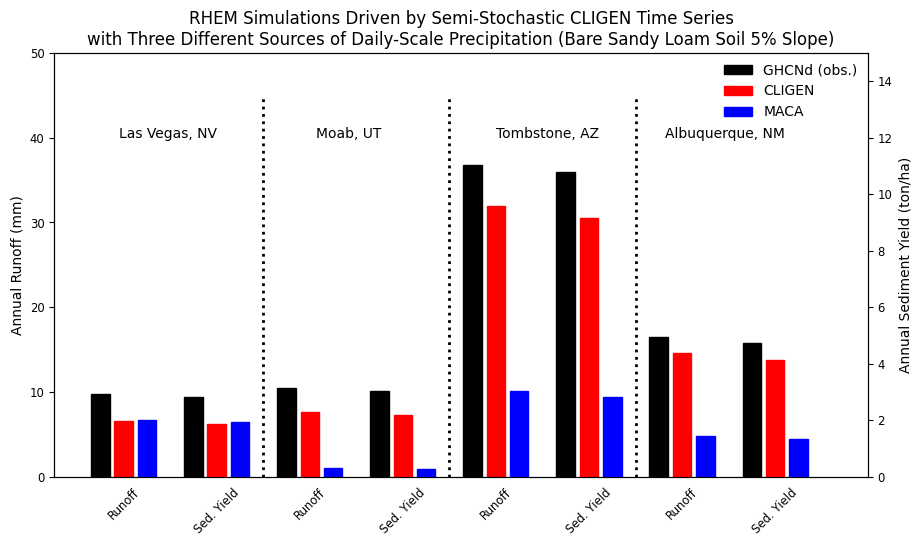

In [15]:
import os
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import pandas as pd

rhemDIR = '/content/drive/MyDrive/Colab Notebooks/MACA_CLIGEN_Comparison/RHEM_CLIGEN_V24_RUN_Example_11Jan2024'

files = os.listdir(rhemDIR)
files = [f for f in files if f[-3:] == 'out']
print(files)


az028619 = pd.read_csv(os.path.join(rhemDIR,'r_az028619.out'), delim_whitespace=True, skiprows=[1])
az028619_ghcn = pd.read_csv(os.path.join(rhemDIR,'r_az028619_ghcn.out'), delim_whitespace=True, skiprows=[1])
az028619_maca = pd.read_csv(os.path.join(rhemDIR,'r_az028619_maca.out'), delim_whitespace=True, skiprows=[1])
nm290234 = pd.read_csv(os.path.join(rhemDIR,'r_nm290234.out'), delim_whitespace=True, skiprows=[1])
nm290234_ghcn = pd.read_csv(os.path.join(rhemDIR,'r_nm290234_ghcn.out'), delim_whitespace=True, skiprows=[1])
nm290234_maca = pd.read_csv(os.path.join(rhemDIR,'r_nm290234_maca.out'), delim_whitespace=True, skiprows=[1])
nv264436 = pd.read_csv(os.path.join(rhemDIR,'r_nv264436.out'), delim_whitespace=True, skiprows=[1])
nv264436_ghcn = pd.read_csv(os.path.join(rhemDIR,'r_nv264436_ghcn.out'), delim_whitespace=True, skiprows=[1])
nv264436_maca = pd.read_csv(os.path.join(rhemDIR,'r_nv264436_maca.out'), delim_whitespace=True, skiprows=[1])
ut425733 = pd.read_csv(os.path.join(rhemDIR,'r_ut425733.out'), delim_whitespace=True, skiprows=[1])
ut425733_ghcn = pd.read_csv(os.path.join(rhemDIR,'r_ut425733_ghcn.out'), delim_whitespace=True, skiprows=[1])
ut425733_maca = pd.read_csv(os.path.join(rhemDIR,'r_ut425733_maca.out'), delim_whitespace=True, skiprows=[1])


az028619_runoff = az028619['Q-runoff'].sum()/40.
az028619_sedyld = az028619['Sed-Yield'].sum()/40.
az028619_ghcn_runoff = az028619_ghcn['Q-runoff'].sum()/40.
az028619_ghcn_sedyld = az028619_ghcn['Sed-Yield'].sum()/40.
az028619_maca_runoff = az028619_maca['Q-runoff'].sum()/40.
az028619_maca_sedyld = az028619_maca['Sed-Yield'].sum()/40.

nm290234_runoff = nm290234['Q-runoff'].sum()/40.
nm290234_sedyld = nm290234['Sed-Yield'].sum()/40.
nm290234_ghcn_runoff = nm290234_ghcn['Q-runoff'].sum()/40.
nm290234_ghcn_sedyld = nm290234_ghcn['Sed-Yield'].sum()/40.
nm290234_maca_runoff = nm290234_maca['Q-runoff'].sum()/40.
nm290234_maca_sedyld = nm290234_maca['Sed-Yield'].sum()/40.

nv264436_runoff = nv264436['Q-runoff'].sum()/40.
nv264436_sedyld = nv264436['Sed-Yield'].sum()/40.
nv264436_ghcn_runoff = nv264436_ghcn['Q-runoff'].sum()/40.
nv264436_ghcn_sedyld = nv264436_ghcn['Sed-Yield'].sum()/40.
nv264436_maca_runoff = nv264436_maca['Q-runoff'].sum()/40.
nv264436_maca_sedyld = nv264436_maca['Sed-Yield'].sum()/40.

ut425733_runoff = ut425733['Q-runoff'].sum()/40.
ut425733_sedyld = ut425733['Sed-Yield'].sum()/40.
ut425733_ghcn_runoff = ut425733_ghcn['Q-runoff'].sum()/40.
ut425733_ghcn_sedyld = ut425733_ghcn['Sed-Yield'].sum()/40.
ut425733_maca_runoff = ut425733_maca['Q-runoff'].sum()/40.
ut425733_maca_sedyld = ut425733_maca['Sed-Yield'].sum()/40.


params = {'xtick.labelsize':'small',
          'ytick.labelsize':'small'}
pylab.rcParams.update(params)

f = plt.figure()
f.set_size_inches(10.5, 5.5)
ax0 = f.add_subplot(111)
ax1 = ax0.twinx()
ax0.tick_params(bottom=False)

width = 0.4

ax0.set_title('RHEM Simulations Driven by Semi-Stochastic CLIGEN Time Series\nwith Three Different Sources of Daily-Scale Precipitation (Bare Sandy Loam Soil 5% Slope)')
ax0.set_ylabel('Annual Runoff (mm)')
ax1.set_ylabel('Annual Sediment Yield (ton/ha)')
ax0.set_ylim(0, 50)
ax1.set_ylim(0, 15)
ax0.set_xticks([1, 5, 9, 13, 17, 21, 25, 29],
                    ['Runoff', 'Sed. Yield',
                     'Runoff', 'Sed. Yield',
                     'Runoff', 'Sed. Yield',
                     'Runoff', 'Sed. Yield'],
                     rotation=45)

maxgraphdots = 45

a, b, c, d = LasVegasNVrunoff = ax0.bar([0, 1, 2, 3], [nv264436_ghcn_runoff, nv264436_runoff, nv264436_maca_runoff, 0.])
LasVegasNVrunoff[0].set_color('black')
LasVegasNVrunoff[1].set_color('red')
LasVegasNVrunoff[2].set_color('blue')

LasVegasNVsedyld = ax1.bar([4, 5, 6, 7], [nv264436_ghcn_sedyld, nv264436_sedyld, nv264436_maca_sedyld, 0.])
LasVegasNVsedyld[0].set_color('black')
LasVegasNVsedyld[1].set_color('red')
LasVegasNVsedyld[2].set_color('blue')

ax0.text(0.8, 40, 'Las Vegas, NV')
ax0.vlines(x=7, ymin=0, ymax=maxgraphdots, colors='black', ls=':', lw=2, label='vline_single - full height')
ax0.text(9.25, 40, 'Moab, UT')

MoabUTrunoff = ax0.bar([8, 9, 10, 11], [ut425733_ghcn_runoff, ut425733_runoff, ut425733_maca_runoff, 0.])
MoabUTrunoff[0].set_color('black')
MoabUTrunoff[1].set_color('red')
MoabUTrunoff[2].set_color('blue')

MoabUTsedyld = ax1.bar([12, 13, 14, 15], [ut425733_ghcn_sedyld, ut425733_sedyld, ut425733_maca_sedyld, 0.])
MoabUTsedyld[0].set_color('black')
MoabUTsedyld[1].set_color('red')
MoabUTsedyld[2].set_color('blue')

ax0.vlines(x=15, ymin=0, ymax=maxgraphdots, colors='black', ls=':', lw=2, label='vline_single - full height')
ax0.text(17, 40, 'Tombstone, AZ')

TombstoneAZrunoff = ax0.bar([16, 17, 18, 19], [az028619_ghcn_runoff, az028619_runoff, az028619_maca_runoff, 0.])
TombstoneAZrunoff[0].set_color('black')
TombstoneAZrunoff[1].set_color('red')
TombstoneAZrunoff[2].set_color('blue')

TombstoneAZsedyld = ax1.bar([20, 21, 22, 23], [az028619_ghcn_sedyld, az028619_sedyld, az028619_maca_sedyld, 0.])
TombstoneAZsedyld[0].set_color('black')
TombstoneAZsedyld[1].set_color('red')
TombstoneAZsedyld[2].set_color('blue')

ax0.vlines(x=23, ymin=0, ymax=maxgraphdots, colors='black', ls=':', lw=2, label='vline_single - full height')
ax0.text(24.25, 40, 'Albuquerque, NM')

AlbuquerqueNMrunoff = ax0.bar([24, 25, 26, 27], [nm290234_ghcn_runoff, nm290234_runoff, nm290234_maca_runoff, 0.])
AlbuquerqueNMrunoff[0].set_color('black')
AlbuquerqueNMrunoff[1].set_color('red')
AlbuquerqueNMrunoff[2].set_color('blue')

AlbuquerqueNMsedyld = ax1.bar([28, 29, 30, 31], [nm290234_ghcn_sedyld, nm290234_sedyld, nm290234_maca_sedyld, 0.])
AlbuquerqueNMsedyld[0].set_color('black')
AlbuquerqueNMsedyld[1].set_color('red')
AlbuquerqueNMsedyld[2].set_color('blue')

ax0.legend(handles=[a, b, c], labels=['GHCNd (obs.)', 'CLIGEN', 'MACA'], loc='upper right', fontsize=10, frameon=False, borderpad=0.25, handlelength=2)

plt.show()




